## Import

In [18]:
import math
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import nibabel as nib
from nibabel.brikhead import *

from nilearn import plotting

[0] Data preparation 
Let’s suppose the following for the measured BOLD signal (TR = 2 s).   
(a) Each of the task was performed at 20 s during 4 s (i.e., 10th and 11th TRs). Please use the boxcar model for neural activity

(b) Consider the 0 – 20 s (i.e., 0th – 9th TRs) and 40 s – 60 s (i.e., 20th – 29th TRs) as baseline period

(c) Calculate the percentage (%) BOLD (pBOLD) signal based on (b)

(d) Conduct the estimation of the HRFs using the pBOLD signals calculated in (c) by applying each of the following methods [1]  [4]. 

When estimating HRFs, please use the pBOLD signal between 18 s – 52 s (i.e., 8th to 25th TRs) which includes a task-related period in between the baseline periods


### Load Subject

In [2]:
sub_id = 2
sub_id = f'{str(sub_id).zfill(2)}'

dir_sub_id = f'./data/s{sub_id}/ad_lh_rh_vs/s{sub_id}.results/*'

In [107]:
ad_raw_brik = nib.load(glob(dir_sub_id)[0])
ad_img_brik = ad_raw_brik.get_fdata()

In [108]:
lh_raw_brik = nib.load(glob(dir_sub_id)[1])
lh_img_brik = lh_raw_brik.get_fdata()

In [109]:
rh_raw_brik = nib.load(glob(dir_sub_id)[2])
rh_img_brik = rh_raw_brik.get_fdata()

In [110]:
vs_raw_brik = nib.load(glob(dir_sub_id)[3])
vs_img_brik = vs_raw_brik.get_fdata()

### Load ROI Mask

In [4]:
masks = { # {task: [(x, y, z) ...]}
    k: [(x, y, z) for x, y, z in zip(*np.where(nib.load(v).get_fdata() != 0)[:-1])]
    for k, v in zip(['ad', 'lh', 'rh', 'vs'], glob('./stats/ttest/*.gz'))
}

In [111]:
ad_roi_total = np.sum(ad_img_brik[p] for p in masks['ad']) / len(masks['ad'])
lh_roi_total = np.sum(lh_img_brik[p] for p in masks['lh']) / len(masks['lh'])
rh_roi_total = np.sum(rh_img_brik[p] for p in masks['rh']) / len(masks['rh'])
vs_roi_total = np.sum(vs_img_brik[p] for p in masks['vs']) / len(masks['vs'])

C:\Users\1_pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.
C:\Users\1_pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
C:\Users\1_pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\1_pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarni

In [117]:
def plot(roi_total, task='ad'):
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    titlesize = 17
    labelsize = 15
    tickssize = 13
    
    ax[0].plot(lh_roi_total)
    ax[0].set_title(f'{task.capitalize()} Averaged BOLD Signal', fontsize=titlesize)
    ax[0].set_xlabel('TR', fontsize=labelsize)
    ax[0].set_ylabel('BOLD signal Change', fontsize=labelsize)
    ax[0].tick_params('x', labelsize=tickssize)
    ax[0].tick_params('y', labelsize=tickssize)
    ax[0].grid()
    ax[0].axvline(11, color='red')
    ax[0].axvline(21, color='red')
    
    ax[1].plot(pd.Series(lh_roi_total).pct_change())
    ax[1].set_title(f'{task.capitalize()} Percentage Change BOLD Signal', fontsize=titlesize)
    ax[1].set_xlabel('TR', fontsize=labelsize)
    ax[1].set_ylabel('% Change', fontsize=labelsize)
    ax[1].tick_params('x', labelsize=tickssize)
    ax[1].tick_params('y', labelsize=tickssize)
    ax[1].grid()
    ax[1].axvline(11, color='red')
    ax[1].axvline(21, color='red')

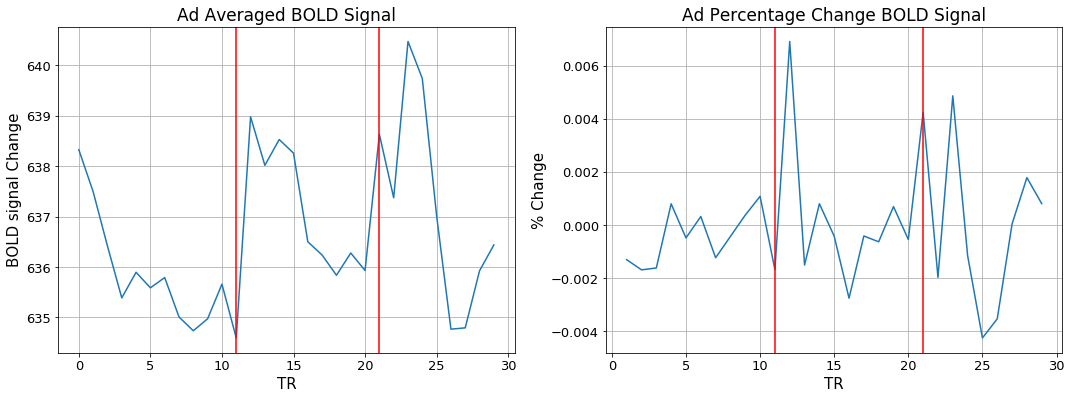

In [118]:
plot(ad_roi_total, 'ad')

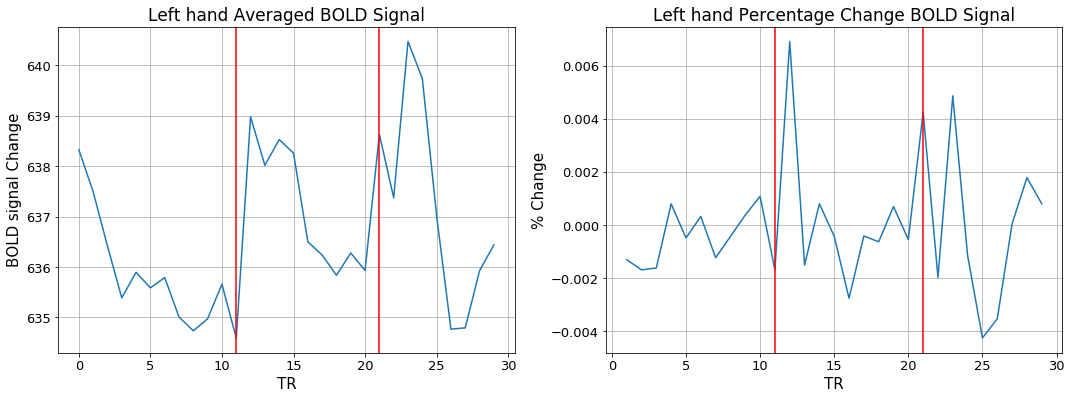

In [119]:
plot(lh_roi_total, 'left hand')

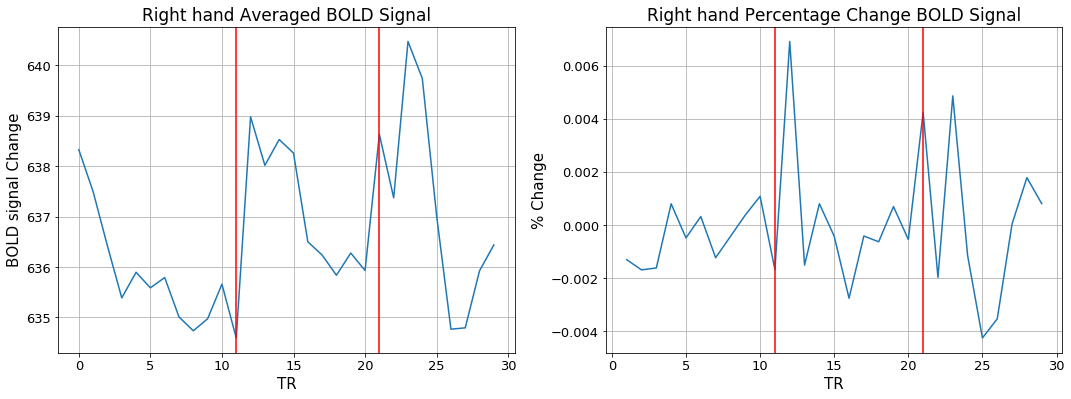

In [120]:
plot(rh_roi_total, 'right hand')

## Gamma by myself

Gamma function defined as follows   
$h(t) = \frac{(t-T_0) ^{n-1}}{\lambda ^n (n-1)!}e^{-t/\lambda}$ for $t > T_0$

In [13]:
def gamma(t, t0, n, lamb):
    
    t[t < t0] = 0
    return (t - t0)**(n-1) / (lamb**n * math.factorial(n-1)) * np.exp(-t/lamb)

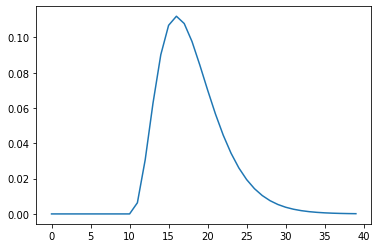

In [17]:
plt.plot(gamma(np.arange(-10, 30), 0, 4, 2))